In [2]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, Activation, concatenate,Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=1.2962e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return (self.b * (2 * x))/ (2**(1/2) * np.pi**(1/4))
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return (((2*x*(h1)))-2)/(2*(np.pi**(1/4))*np.sqrt(math.factorial(2)))
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return (((2 * x * (h2)))-(4 * h1)) / (2**(3/2)*(np.pi**(1/4))*np.sqrt(math.factorial(3)))

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return (((2*x*(h3)))-(6*h2)) / (2**2 *(np.pi**(1/4))*np.sqrt(math.factorial(4)))

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return (((2 * x * h4)) - (8 * h3)) / (2**(5/2) * (np.pi**(1/4)) * np.sqrt(math.factorial(5)))

#FROM THIS ON NO MODIFICATION ON WEIGHTS
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)


2024-05-15 13:42:32.341203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 13:42:32.359148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 13:42:32.359342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 3)            12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['batch_normalization[0][0]'] 
                                                                                                  
 h1_layer (H1Layer)          (None, 16, 16, 64)           64        ['conv2d[0][0]']          

2024-05-15 13:42:34.814636: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-15 13:42:35.557523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-15 13:42:36.183390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-15 13:42:36.184783: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x207d15d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 13:42:36.184826: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-15 13:42:36.190829: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabl

391/391 [==============================] - 6s 6ms/step - loss: 1.7131 - accuracy: 0.3773 - val_loss: 1.4100 - val_accuracy: 0.4953
Epoch 2/30
391/391 [==============================] - 2s 5ms/step - loss: 1.3586 - accuracy: 0.5134 - val_loss: 1.1968 - val_accuracy: 0.5823
Epoch 3/30
391/391 [==============================] - 2s 5ms/step - loss: 1.2372 - accuracy: 0.5605 - val_loss: 1.1038 - val_accuracy: 0.6149
Epoch 4/30
391/391 [==============================] - 2s 5ms/step - loss: 1.1663 - accuracy: 0.5853 - val_loss: 1.0584 - val_accuracy: 0.6301
Epoch 5/30
391/391 [==============================] - 2s 5ms/step - loss: 1.1166 - accuracy: 0.6061 - val_loss: 1.0186 - val_accuracy: 0.6478
Epoch 6/30
391/391 [==============================] - 2s 5ms/step - loss: 1.0752 - accuracy: 0.6198 - val_loss: 0.9903 - val_accuracy: 0.6545
Epoch 7/30
391/391 [==============================] - 2s 5ms/step - loss: 1.0440 - accuracy: 0.6333 - val_loss: 0.9638 - val_accuracy: 0.6662
Epoch 8/30
391/39

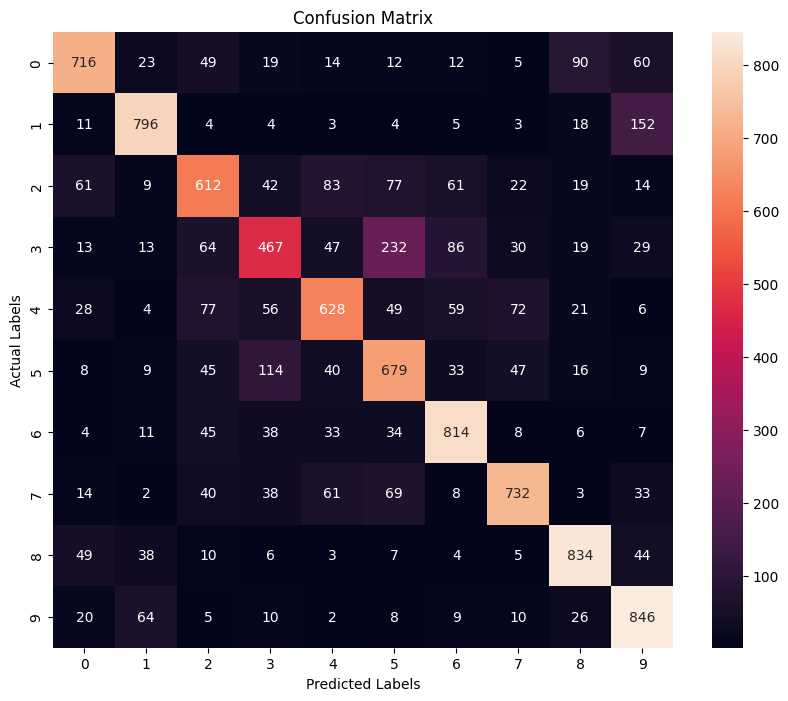

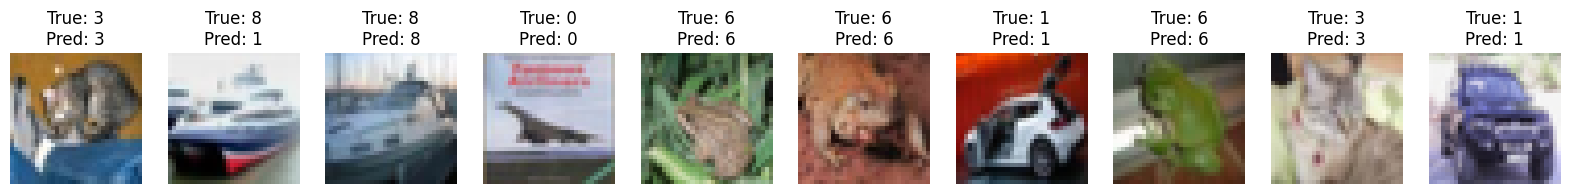

In [2]:
import tensorflow as tf
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    x = BatchNormalization()(x)

    x = Conv2D(filters=filters, kernel_size=(7,7), strides=2, padding='same',kernel_initializer="he_normal")(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(5, 5), padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    
    x = MaxPooling2D((4,4))(x)
    x = Dropout(rate=0.5)(x)

    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 128
epochs = 30

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()



In [4]:
# Clear the session to free up GPU memory
tf.keras.backend.clear_session()

#FORGET PREVIOUS MODEL
del model_img
gc.collect()

15747

2024-05-15 14:00:36.516844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 14:00:36.535509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 14:00:36.535706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 3)            12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['batch_normalization[0][0]'] 
                                                                                                  
 h1_layer (H1Layer)          (None, 16, 16, 64)           64        ['conv2d[0][0]']          

s-bus-pci#L344-L355
2024-05-15 14:00:36.537826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 14:00:36.537951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 14:00:36.964291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

Epoch 1/100


2024-05-15 14:00:38.276670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-15 14:00:39.039947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-15 14:00:39.642988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-15 14:00:39.644368: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e68e100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 14:00:39.644405: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-15 14:00:39.650530: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabl

782/782 [==============================] - 18s 19ms/step - loss: 1.8349 - accuracy: 0.3985 - val_loss: 1.4933 - val_accuracy: 0.5169 - lr: 0.0010
Epoch 2/100
782/782 [==============================] - 14s 18ms/step - loss: 1.5610 - accuracy: 0.4893 - val_loss: 1.3396 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 3/100
782/782 [==============================] - 14s 18ms/step - loss: 1.4717 - accuracy: 0.5239 - val_loss: 1.2685 - val_accuracy: 0.5965 - lr: 0.0010
Epoch 4/100
782/782 [==============================] - 14s 18ms/step - loss: 1.4254 - accuracy: 0.5432 - val_loss: 1.2382 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 5/100
782/782 [==============================] - 14s 18ms/step - loss: 1.3941 - accuracy: 0.5565 - val_loss: 1.2152 - val_accuracy: 0.6162 - lr: 0.0010
Epoch 6/100
782/782 [==============================] - 14s 18ms/step - loss: 1.3662 - accuracy: 0.5687 - val_loss: 1.2198 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 7/100
782/782 [==============================] - 14s 18ms/

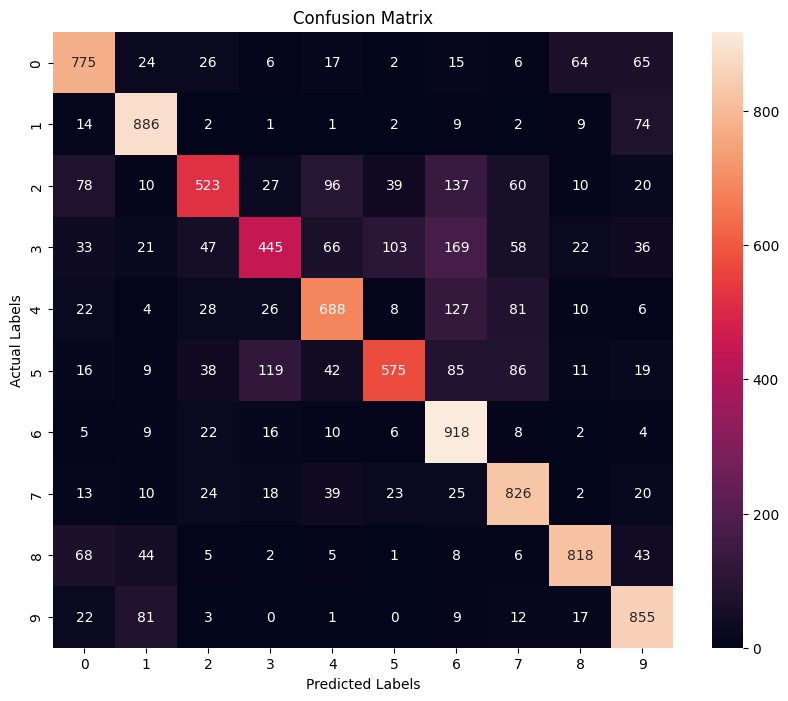

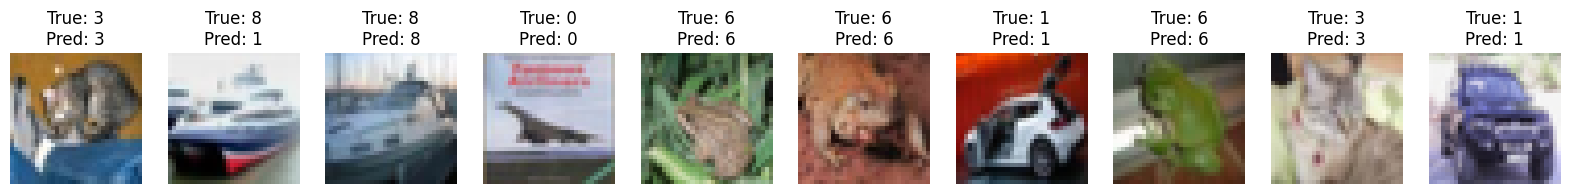

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Input, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Data Augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    shear_range=0.1
)
datagen.fit(x_train)

def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()

    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=(7, 7), strides=2, padding='same', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(5, 5), padding='same', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = x_h2 = h2(x, x_h1)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = x_h3 = h3(x, x_h1, x_h2)

    x = MaxPooling2D((2, 2))(x)
    x = Dropout(rate=0.5)(x)
    x = Flatten()(x)
    output_layer = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

input_shape = (32, 32, 3)
num_classes = 10
filters = 64
model = build_model(input_shape, num_classes, filters)
model.summary()

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

batch_size = 64
epochs = 100

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler, early_stopping],
                    verbose=1)

val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
y_pred = model.predict(x_test)
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(x_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Input, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Data Augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    shear_range=0.1
)
datagen.fit(x_train)

def residual_block(x, filters, h1, h2, h3):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = h1(x)
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = h2(x, shortcut)
    x = Add()([x, shortcut])
    x = h3(x, shortcut, x)
    return x

def build_model(input_shape, num_classes, filters):
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()

    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=(7, 7), strides=2, padding='same', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = h1(x)
    
    x = residual_block(x, filters, h1, h2, h3)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(rate=0.3)(x)

    x = residual_block(x, filters*2, h1, h2, h3)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(rate=0.4)(x)

    x = residual_block(x, filters*4, h1, h2, h3)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)

    output_layer = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

input_shape = (32, 32, 3)
num_classes = 10
filters = 64
model = build_model(input_shape, num_classes, filters)
model.summary()

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

batch_size = 64
epochs = 100

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler, early_stopping],
                    verbose=1)

val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
y_pred = model.predict(x_test)
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(x_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()


2024-05-15 14:36:06.963098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 14:36:06.981597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 14:36:06.981787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ValueError: Exception encountered when calling layer "h1_layer" (type H1Layer).

in user code:

    File "/tmp/ipykernel_523773/2572877143.py", line 66, in call  *
        return (self.b * (2 * x))/ (2**(1/2) * np.pi**(1/4))

    ValueError: Dimensions must be equal, but are 64 and 128 for '{{node h1_layer/mul_1}} = Mul[T=DT_FLOAT](h1_layer/ReadVariableOp, h1_layer/mul)' with input shapes: [64], [?,8,8,128].


Call arguments received by layer "h1_layer" (type H1Layer):
  • x=tf.Tensor(shape=(None, 8, 8, 128), dtype=float32)